# Modelling Customer Satisfaction

##### The aim of this project is to model customer satisfaction for a logistics and delivery startup. The dataset we will be working with was collected via a customer satisfaction survey, and provided by the startup. Our goal is to create a model that predicts customer satisfaction given responses to the other questions in the survey. Furthermore, our aim is to create an easily interpretable model, so that the startup can learn where it needs to improve its service to improve customer satisfaction. 

Useful python libraries and functions to use later on

In [1]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [39]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):
    '''
    Plots the confusion matrix, given relevant data.
    '''
    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [4]:
from matplotlib.patches import Patch

def plot_coefs(all_coeffs, order, title):
    '''
    Function for plotting a barplot of the coefficients of the fitted model.
    Will be used in logistic regression model.
    '''
    # setting colors for positive and negative coefficients.
    colors = ['red' if value > 0 else 'blue' for value in all_coeffs]
    
    plt.bar(range(len(all_coeffs)),all_coeffs, align='center', color=colors)
    plt.xticks(range(len(order)), order, size='small',rotation = 70)
    plt.tight_layout
    # Create custom legend entries
    legend_handles = [
        Patch(color='red', label='Positive'),
        Patch(color='blue', label='Negative')
    ]
    
    plt.legend(handles=legend_handles)
    
    # Set labels and title
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)

#### **EDA**

Description of data

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers\
X1 = my order was delivered on time\
X2 = contents of my order was as I expected\
X3 = I ordered everything I wanted to order\
X4 = I paid a good price for my order\
X5 = I am satisfied with my courier\
X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

Thus, in this project, we are dealing with a classification problem. Our target variable is Y and our feature variables are X1 to X6.


In [40]:
import pandas as pd
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


##### Comments

Above we see that the dataset consists of 126 data points. Thus, we are working with a relatively small dataset. Fortunately, there appear to be no null values in the dataset.

In [9]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


##### Comments

Above we see that the mean of the target variable is approximately 0.548. Thus, it appears that there is a fairly even split between Y = 0 and Y = 1 cases. Therefore, the dataset does not appear to be imbalanced. The distribution of the features (X1-X6) is less clear from the table above. Below, we will plot the distributions.

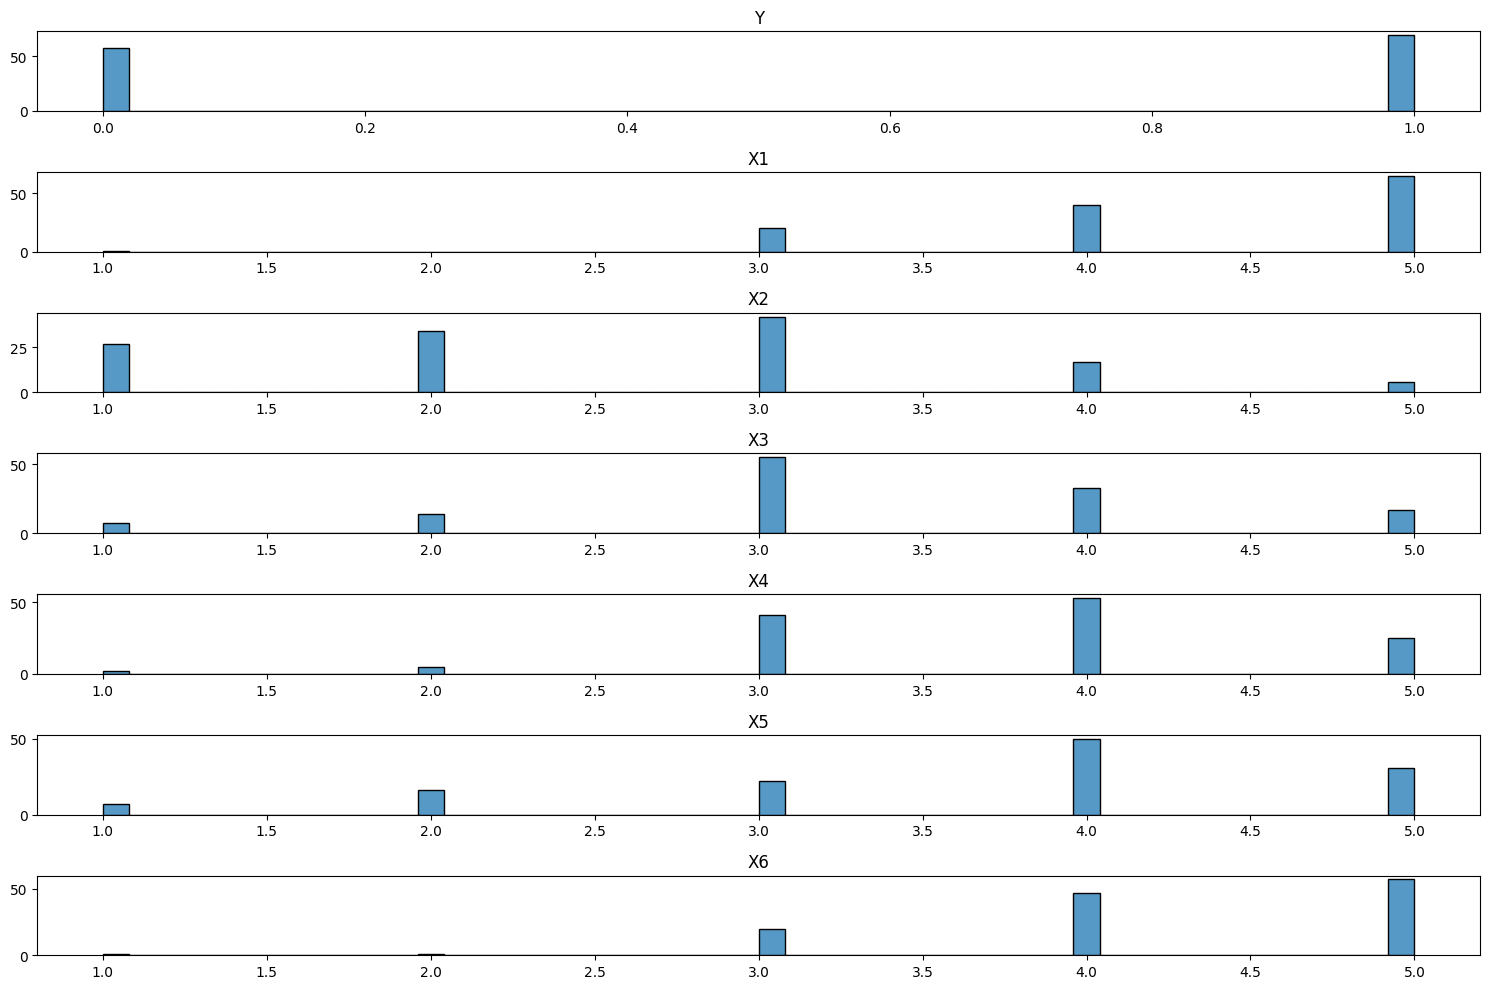

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=7)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Comments

The first thing to note is that the scale of all our feature variables is the same (1-5). Above, we can clearly see that the distributions of the X1, X4, X5 and X6 variables are skewed to the right. The distribution of the X2 is slightly skewed to the left. The distribution of the X3 variable is most normally distributed.

Furthermore, we can note that there are very few instances of X1 = 1,2 and X6 = 1,2. Below, we calculate the exact number of these instances.


In [11]:
df["X1"].value_counts()

X1
5    65
4    40
3    20
1     1
Name: count, dtype: int64

In [12]:
df["X6"].value_counts()

X6
5    57
4    47
3    20
2     1
1     1
Name: count, dtype: int64

##### Correlation Table

Below we plot the correlation heatmap. Interestingly, there are no two variables which appear strongly correlated. The hightest correlation coefficient value in the heatmap is only 0.43 (between X1 and X5). Therefore, no clear relationship between any two variables stands out in this heatmap. Looking at the row corresponding to Y, we see that the correlation coefficients between Y and X2, and Y and X4 are particularly close to zero.

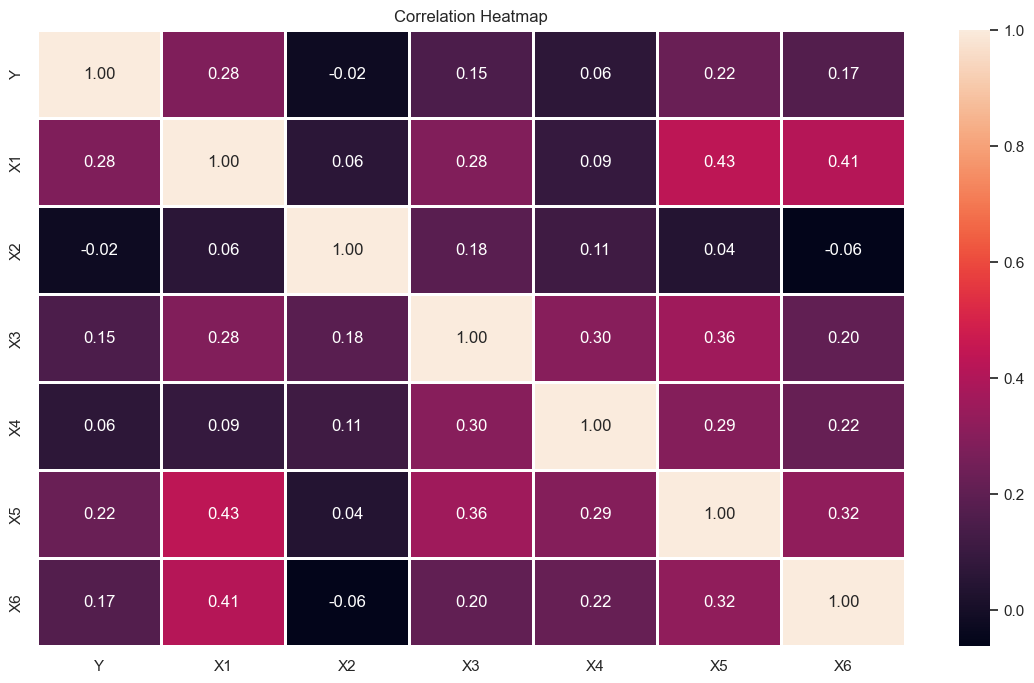

In [13]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

#### **EDA Comments**

From the EDA, we have learned a lot about the dataset. One of the most important takeaways is that the startup is performing poorly. The number of dissatisfied and satisfied customers is fairly evenly split. Thus, it is imperative that the startup improves customer satisfaction. To this end, we will design a classification machine learning model which will attempt to model customer satisfaction given values of the feature variables.

Below is a table describing the main takeaways from the EDA, with their corresponding consequences for our models.

| Issue    | Consequences for Model |
|----------|----------|
| Fairly even split between Y = 0 and Y = 1 cases | As dataset is balanced, there is no need to perform upsampling  |
| Feature variables are all on same scale (1-5) | No need to perform feature engineering on feature scale |
| Few instances of X1 = 1,2 and X6 = 1,2 | Consider removing these datapoints, as they could cause issues down the line | 
| Correlation coefficients between Y and X2, and Y and X4 are close to zero | Consider removing features X2 and/or X4, to make feature space smaller | 

#### Data Clean Up and Feature Engineering

In our EDA, we saw that the dataset was fairly straightforward and required little clean up or feature engineering. The only potential feature engineering step that could be included in our model pipelines is to remove the feature variables X2 and/or X4. Below, we will try three cases: with X2 and X4, without X2, and without X2 and X4. 

In [14]:
'''
X = df.drop('Y', axis = 1)
Y = df["Y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

X_ = X.drop('X2', axis = 1)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, Y, test_size=0.2, random_state=123)

X_red = X_.drop('X4', axis = 1)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, Y, test_size=0.2, random_state=123)

'''


Classification models can exhibit high degrees of sensitivity to training and test datasets, when working with small datasets. As our dataset is small, it is adviseable to save the test and training datasets, so that the same sets are used each time for every model.

In [ ]:
'''
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

X_train_.to_csv("X_train_.csv", index=False)
X_test_.to_csv("X_test_.csv", index=False)
y_train_.to_csv("y_train_.csv", index=False, header=True)
y_test_.to_csv("y_test_.csv", index=False, header=True)

X_train_red.to_csv("X_train_red.csv", index=False)
X_test_red.to_csv("X_test_red.csv", index=False)
y_train_red.to_csv("y_train_red.csv", index=False, header=True)
y_test_red.to_csv("y_test_red.csv", index=False, header=True)

'''



Reading datasets

In [44]:
import pandas as pd

X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")

X_train_ = pd.read_csv("X_train_.csv")
X_test_ = pd.read_csv("X_test_.csv")

y_train_ = pd.read_csv("y_train_.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test_ = pd.read_csv("y_test_.csv").squeeze("columns")

X_train_red = pd.read_csv("X_train_red.csv")
X_test_red = pd.read_csv("X_test_red.csv")

y_train_red = pd.read_csv("y_train_red.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test_red = pd.read_csv("y_test_red.csv").squeeze("columns")


#### Lazy Predict

To gain some idea as to which classification models will likely perform better for our dataset, we will use Lazy Predict. 

In [46]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

##### Full dataset

In [45]:
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]

[LightGBM] [Info] Number of positive: 59, number of negative: 41
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590000 -> initscore=0.363965
[LightGBM] [Info] Start training from score 0.363965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

##### Dataset without X2 feature

In [88]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_, X_test_, y_train_, y_test_)

print(models)

100%|██████████| 32/32 [00:01<00:00, 16.52it/s]

[LightGBM] [Info] Number of positive: 59, number of negative: 41
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590000 -> initscore=0.363965
[LightGBM] [Info] Start training from score 0.363965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

##### Dataset without X2 and X4 features

In [47]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_red, X_test_red, y_train_red, y_test_red)

print(models)

100%|██████████| 32/32 [00:02<00:00, 12.59it/s]

[LightGBM] [Info] Number of positive: 59, number of negative: 41
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590000 -> initscore=0.363965
[LightGBM] [Info] Start training from score 0.363965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

##### Analysis of Lazy Predict Results

Above, we have seen that the optimal model depends on the dataset. Furthermore, we have seen that working with reduced datasets (without X2 feature, and X2 and X4 feature) appears to improve model performance. That said, we have seen that none of the models appear to perform that well according to the predictions of Lazy Predict. Thus, the problem at hand is non-trivial. 

Given the time constraints of the project, it is not possible to investigate all the permutations of the different models and datasets. After consulting the top performing models in the above tables, I note that the models that come up most regularly in all three tables are the following: decision tree (with its many ensemble method relatives) and SVC. In this project, we will thus work with decision tree models (including bagging classifiers, random forests and extra tree models) SVC models. Furthermore, we may use a logistic regression model as a baseline model. All the above mentioned models are good as they are all fairly easy to interpret.

In [81]:

from sklearn.preprocessing import label_binarize
from imblearn.metrics import specificity_score

def custom_roc_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    if len(np.unique(y)) > 2:  # Multiclass case
        y_bin = label_binarize(y, classes=np.unique(y))
        return roc_auc_score(y_bin, y_prob, multi_class="ovr", average="macro")
    else:  # Binary case
        return roc_auc_score(y, y_prob[:, 1])

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def custom_pr_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return pr_auc_score(y, y_prob)

dtc_pipeline = Pipeline([
    ("model", DecisionTreeClassifier())
])

dtc_param_grid = {
    "model__max_depth": np.arange(3,15,1,dtype = int),
    "model__min_samples_split": np.arange(2,10,1,dtype = int), 
    "model__min_samples_leaf": np.arange(1,8,1,dtype = int),
    "model__class_weight": [None, "balanced"],
    "model__criterion": ["gini", "entropy"], 
    "model__random_state": [42]
}



# Define custom scoring functions for precision and recall
scoring = {
    "accuracy": make_scorer(accuracy_score), 
    "specificity": make_scorer(specificity_score),  
    "precision": make_scorer(precision_score), 
    "recall": make_scorer(recall_score), #focus on negatives
    "negative_recall": make_scorer(recall_score, pos_label=0), #focus on negatives
    "roc_auc": custom_roc_auc_scorer,
    "pr_auc": custom_pr_auc_scorer, "f1_score": make_scorer(f1_score)
}

# Define StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

refit = "negative_recall"
grid_search = GridSearchCV(dtc_pipeline, dtc_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

Best parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(3), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
accuracy: 0.6900000000000001
specificity: 0.8527777777777779
precision: 0.8511904761904763
recall: 0.8527777777777779
roc_auc: 0.7538194444444446
pr_auc: 0.8330994114817644
f1_score: 0.6859649122807017


We then extract the best params here to save them (to avoid losing them due to random effects in our cv etc.)

In [10]:
best_params_dtc = {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(3), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
dtc_pipeline = Pipeline([
    ("model", DecisionTreeClassifier(**best_params_dtc))
])
feature_names_out = X_train.columns


dtc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_depth=np.int64(3),
                                        min_samples_leaf=np.int64(3),
                                        min_samples_split=np.int64(2),
                                        random_state=42))])

Visualising tree

In [11]:
# Get a textual representation of the decision tree
from sklearn.tree import export_text
tree_text = export_text(dtc_pipeline[-1], feature_names=feature_names_out, max_depth=3)
print(tree_text)

|--- X1 <= 4.50
|   |--- X3 <= 4.50
|   |   |--- X6 <= 3.50
|   |   |   |--- class: 0
|   |   |--- X6 >  3.50
|   |   |   |--- class: 0
|   |--- X3 >  4.50
|   |   |--- class: 0
|--- X1 >  4.50
|   |--- X5 <= 3.50
|   |   |--- X5 <= 2.50
|   |   |   |--- class: 1
|   |   |--- X5 >  2.50
|   |   |   |--- class: 0
|   |--- X5 >  3.50
|   |   |--- X4 <= 4.50
|   |   |   |--- class: 1
|   |   |--- X4 >  4.50
|   |   |   |--- class: 1



Feature importance

In [12]:
print(feature_names_out)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')


NameError: name 'fig' is not defined

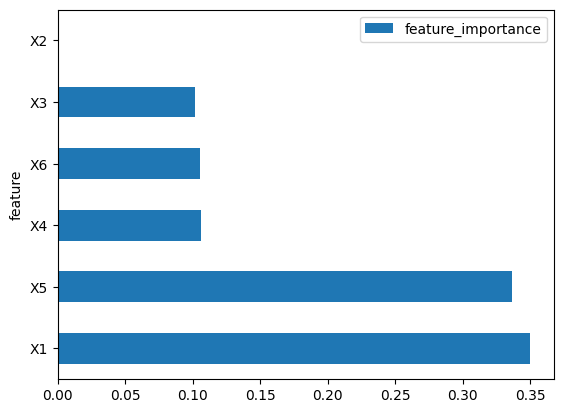

In [17]:

def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_[:len(names)],
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    feature_importance_df.plot(kind="barh")
    fig.show()

plot_feature_importance(dtc_pipeline[-1], feature_names_out)

Again, we see that X2 variable appears to have little effect on customer satisfaction.

              precision    recall  f1-score   support

           0       0.69      0.56      0.62        16
           1       0.46      0.60      0.52        10

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.57        26
weighted avg       0.60      0.58      0.58        26



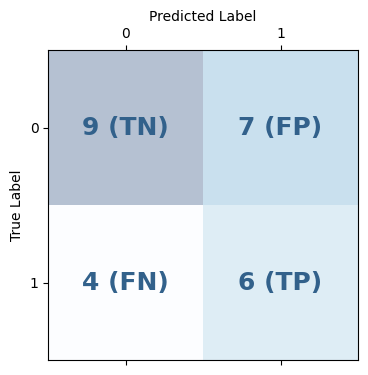

False Positive Rate (FPR): 0.438
Recall: 0.600
Negative Recall: 0.562
Precision: 0.462
F1 Score: 0.522


In [18]:
y_probs = dtc_pipeline.predict_proba(X_test)[:, 1]
y_pred = dtc_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)

# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.615625


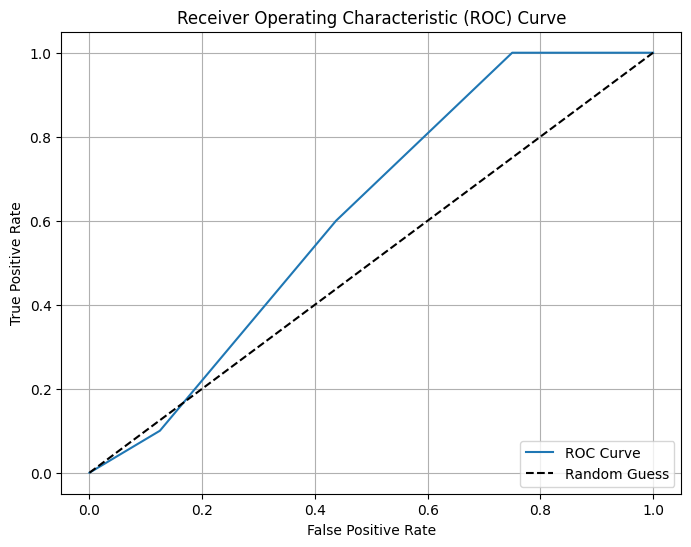

In [19]:
predictions_pa = dtc_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

Decision tree with reduced dataset: without X2 feature

In [20]:
grid_search.fit(X_train_, y_train_)
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out_ = X_train_.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

NameError: name 'grid_search' is not defined

In [21]:
best_params_dtc_ = {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(3), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
dtc_pipeline_ = Pipeline([
    ("model", DecisionTreeClassifier(**best_params_dtc_))
])

dtc_pipeline_.fit(X_train_, y_train_)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_depth=np.int64(3),
                                        min_samples_leaf=np.int64(3),
                                        min_samples_split=np.int64(2),
                                        random_state=42))])

In [23]:
# Get a textual representation of the decision tree
from sklearn.tree import export_text
feature_names_out_ = X_train_.columns

tree_text = export_text(dtc_pipeline_[-1], feature_names=feature_names_out_, max_depth=3)
print(tree_text)

|--- X1 <= 4.50
|   |--- X3 <= 4.50
|   |   |--- X6 <= 3.50
|   |   |   |--- class: 0
|   |   |--- X6 >  3.50
|   |   |   |--- class: 0
|   |--- X3 >  4.50
|   |   |--- class: 0
|--- X1 >  4.50
|   |--- X5 <= 3.50
|   |   |--- X5 <= 2.50
|   |   |   |--- class: 1
|   |   |--- X5 >  2.50
|   |   |   |--- class: 0
|   |--- X5 >  3.50
|   |   |--- X4 <= 4.50
|   |   |   |--- class: 1
|   |   |--- X4 >  4.50
|   |   |   |--- class: 1



NameError: name 'fig' is not defined

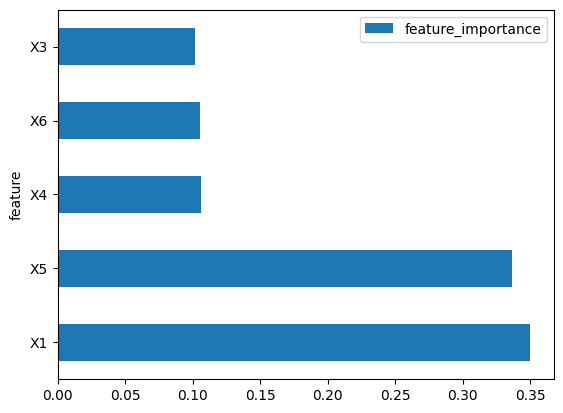

In [24]:

plot_feature_importance(dtc_pipeline_[-1], feature_names_out_)

              precision    recall  f1-score   support

           0       0.69      0.56      0.62        16
           1       0.46      0.60      0.52        10

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.57        26
weighted avg       0.60      0.58      0.58        26



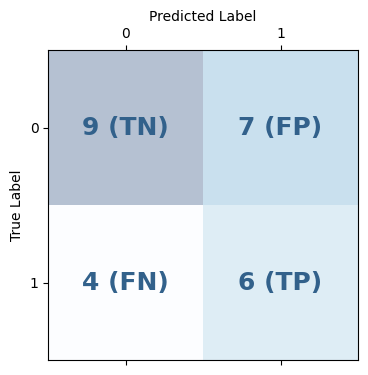

False Positive Rate (FPR): 0.438
Recall: 0.600
Negative Recall: 0.562
Precision: 0.462
F1 Score: 0.522


In [25]:
y_probs = dtc_pipeline_.predict_proba(X_test_)[:, 1]
y_pred = dtc_pipeline_.predict(X_test_)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test_, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train_ = LE.fit_transform(y_train_)
y_test_ = LE.transform(y_test_)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Negative recall
Negative_Recall = (TN)/(TN+FP)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test_, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.615625


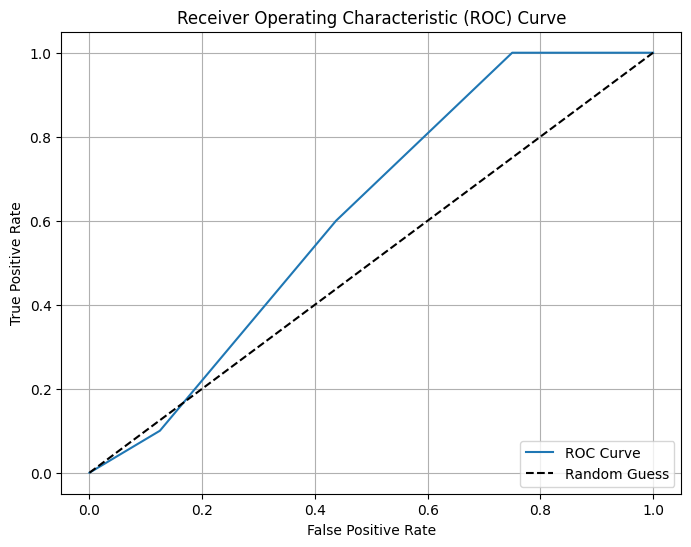

In [26]:
predictions_pa = dtc_pipeline_.predict_proba(X_test_)

roc_calc = roc_curve(y_true = y_test_, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test_, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test_, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

Bagging Model

In [96]:
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import BaggingClassifier
from imblearn.metrics import specificity_score

def custom_roc_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    if len(np.unique(y)) > 2:  # Multiclass case
        y_bin = label_binarize(y, classes=np.unique(y))
        return roc_auc_score(y_bin, y_prob, multi_class="ovr", average="macro")
    else:  # Binary case
        return roc_auc_score(y, y_prob[:, 1])

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def custom_pr_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return pr_auc_score(y, y_prob)

dtc_pipeline = Pipeline([
    ("model", BaggingClassifier(estimator=DecisionTreeClassifier()))
])

dtc_param_grid = {
    "model__estimator__max_depth": np.arange(7, 14, 1, dtype=int),
    "model__estimator__min_samples_split": np.arange(4, 8, 1, dtype=int),
    "model__estimator__min_samples_leaf": np.arange(1, 4, 1, dtype=int),
    "model__estimator__criterion": ["gini", "entropy"],
    "model__estimator__class_weight": [None, "balanced"], 
    "model__n_estimators": np.arange(10, 30, 10, dtype=int),
    "model__max_samples": [0.5, 0.7, 1.0],
    "model__max_features": [1.0],
    "model__bootstrap": [True, False],
    "model__random_state": [42]
}



# Define custom scoring functions for precision and recall
scoring = {
    "accuracy": make_scorer(accuracy_score), 
    "specificity": make_scorer(specificity_score),
    "precision": make_scorer(precision_score), 
    "recall": make_scorer(recall_score),
    "negative_recall": make_scorer(recall_score, pos_label=0), #focus on negatives
    "roc_auc": custom_roc_auc_scorer,
    "pr_auc": custom_pr_auc_scorer, 
    "f1_score": make_scorer(f1_score)
}

# Define StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

refit = "negative_recall"
grid_search = GridSearchCV(dtc_pipeline, dtc_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

Best parameters: {'bootstrap': False, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': 'balanced', 'estimator__criterion': 'entropy', 'estimator__max_depth': np.int64(10), 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': np.int64(2), 'estimator__min_samples_split': np.int64(4), 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=np.int64(10), min_samples_leaf=np.int64(2),
                       min_samples_split=np.int64(4)), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': np.int64(20), 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
accuracy: 0.6
specificity: 0.711111111111111
precision: 0.731111111111111
re

In [27]:
# best model parameters
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=4,
    random_state=None
)

# Define the BaggingClassifier with its parameters
bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=20,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=False,
    bootstrap_features=False,
    random_state=42
)

# Define the pipeline
bag_pipeline = Pipeline([
    ("model", bagging_model)
])

# Fit the pipeline
bag_pipeline.fit(X_train, y_train)

Pipeline(steps=[('model',
                 BaggingClassifier(bootstrap=False,
                                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=10,
                                                                    min_samples_leaf=2,
                                                                    min_samples_split=4),
                                   n_estimators=20, random_state=42))])

Feature Importances:
  Feature  Importance
4      X5    0.242876
0      X1    0.207243
2      X3    0.179726
1      X2    0.146755
5      X6    0.119265
3      X4    0.104135


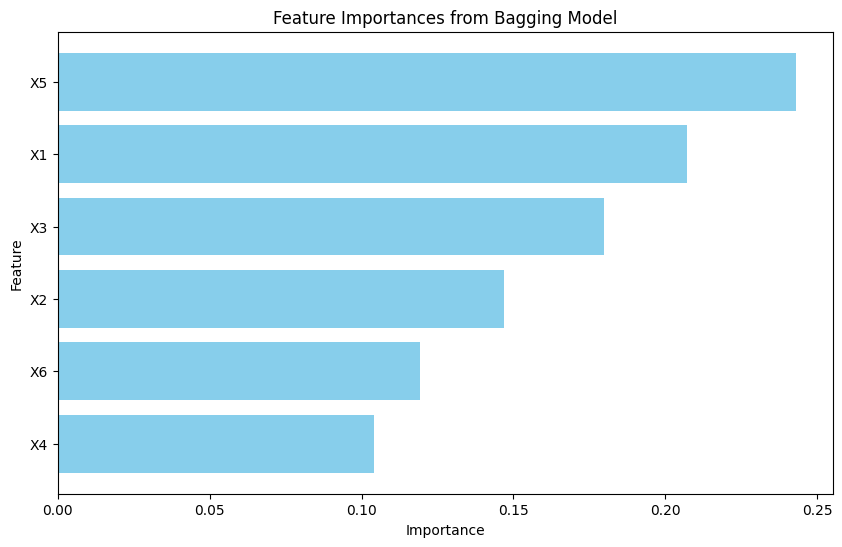

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the BaggingClassifier from the pipeline
bagging_model = bag_pipeline.named_steps["model"]

# Check if the base estimator has feature importances
if hasattr(bagging_model.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    feature_names = X_train.columns  
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Bagging Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")


AUC value: 0.49375


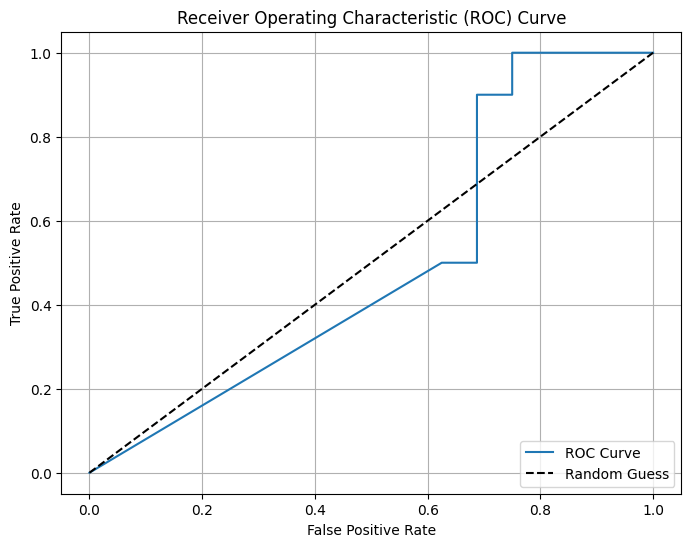

In [29]:
predictions_pa = bag_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

              precision    recall  f1-score   support

           0       0.62      0.31      0.42        16
           1       0.39      0.70      0.50        10

    accuracy                           0.46        26
   macro avg       0.51      0.51      0.46        26
weighted avg       0.53      0.46      0.45        26



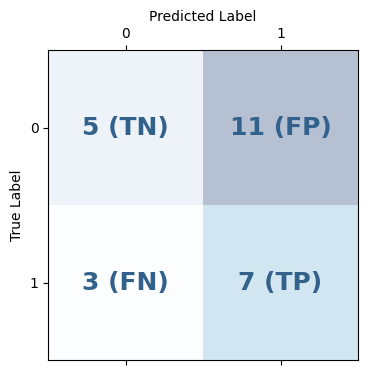

False Positive Rate (FPR): 0.688
Recall: 0.700
Negative Recall: 0.312
Precision: 0.389
F1 Score: 0.500


In [30]:
y_probs = bag_pipeline.predict_proba(X_test)[:, 1]
y_pred = bag_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Negative recall
Negative_Recall = (TN)/(TN+FP)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

Bagging with reduced dataset, X_ (without feature X2)

In [103]:
grid_search = GridSearchCV(dtc_pipeline, dtc_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train_, y_train_)
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train_.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': 'balanced', 'estimator__criterion': 'gini', 'estimator__max_depth': np.int64(7), 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': np.int64(2), 'estimator__min_samples_split': np.int64(6), 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=np.int64(7),
                       min_samples_leaf=np.int64(2),
                       min_samples_split=np.int64(6)), 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': np.int64(20), 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
accuracy: 0.7
specificity: 0.7583333333333333
precision: 0.7999572649572648
recall: 0.6651515151515152


In [31]:
# best model parameters
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    min_samples_leaf=2,
    min_samples_split=6,
    random_state=None
)

# Define the BaggingClassifier with its parameters
bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=20,
    max_samples=0.5,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    random_state=42
)

# Define the pipeline
bag_pipeline_ = Pipeline([
    ("model", bagging_model)
])

# Fit the pipeline
bag_pipeline_.fit(X_train_, y_train_)

Pipeline(steps=[('model',
                 BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                                    min_samples_leaf=2,
                                                                    min_samples_split=6),
                                   max_samples=0.5, n_estimators=20,
                                   random_state=42))])

Feature Importances:
  Feature  Importance
1      X3    0.290322
3      X5    0.257714
0      X1    0.228586
2      X4    0.117271
4      X6    0.106107


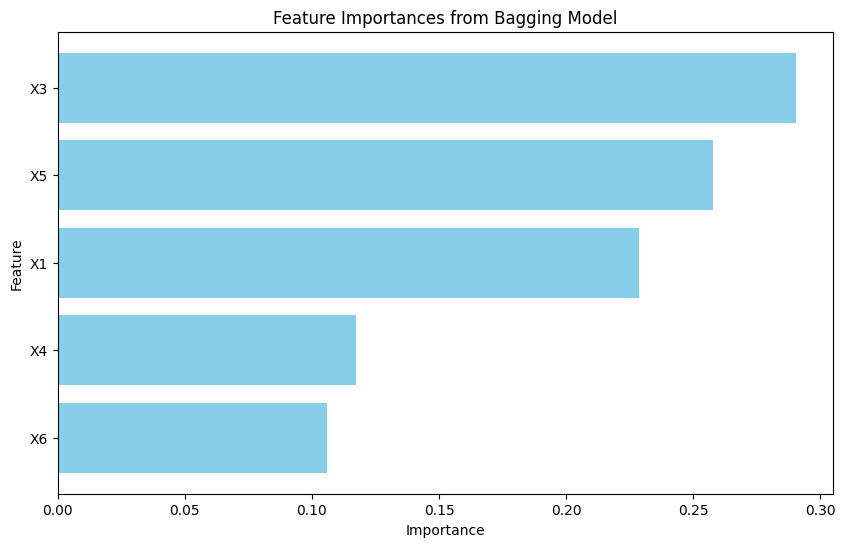

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the BaggingClassifier from the pipeline
bagging_model_ = bag_pipeline_.named_steps["model"]

# Check if the base estimator has feature importances
if hasattr(bagging_model_.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model_.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    feature_names = X_train_.columns  
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Bagging Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")

AUC value: 0.634375


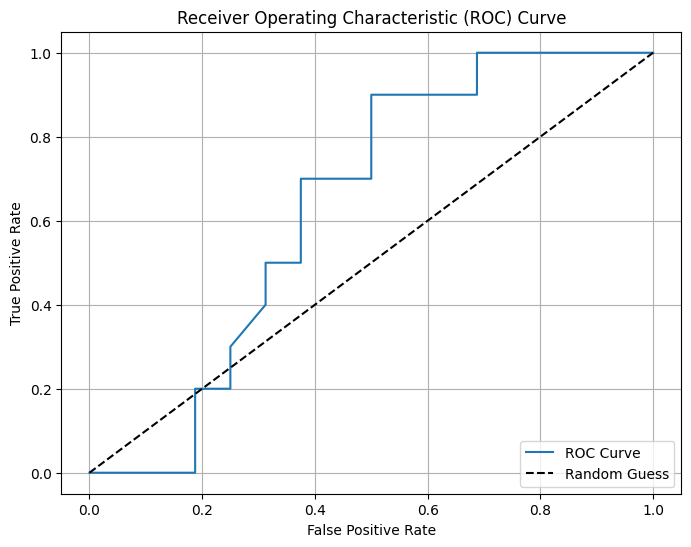

In [33]:
predictions_pa = bag_pipeline_.predict_proba(X_test_)

roc_calc = roc_curve(y_true = y_test_, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test_, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test_, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

              precision    recall  f1-score   support

           0       0.80      0.50      0.62        16
           1       0.50      0.80      0.62        10

    accuracy                           0.62        26
   macro avg       0.65      0.65      0.62        26
weighted avg       0.68      0.62      0.62        26



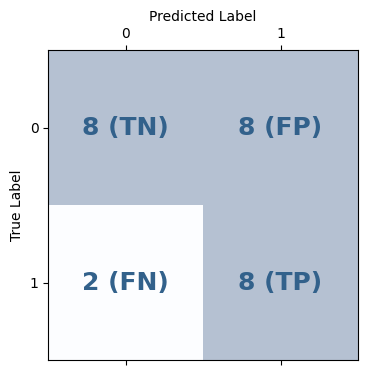

False Positive Rate (FPR): 0.500
Recall: 0.800
Negative Recall: 0.500
Precision: 0.500
F1 Score: 0.615


In [34]:
y_probs = bag_pipeline_.predict_proba(X_test_)[:, 1]
y_pred = bag_pipeline_.predict(X_test_)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test_, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train_ = LE.fit_transform(y_train_)
y_test_ = LE.transform(y_test_)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Negative recall
Negative_Recall = (TN)/(TN+FP)

# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test_, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

Random forests

In [110]:
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

def custom_roc_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    if len(np.unique(y)) > 2:  # Multiclass case
        y_bin = label_binarize(y, classes=np.unique(y))
        return roc_auc_score(y_bin, y_prob, multi_class="ovr", average="macro")
    else:  # Binary case
        return roc_auc_score(y, y_prob[:, 1])

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def custom_pr_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return pr_auc_score(y, y_prob)

rf = Pipeline([
    ("model", RandomForestClassifier())
])

rf_param_grid = {
    "model__n_estimators": [10],  # Number of trees in the forest
    "model__max_depth": [None] + list(np.arange(7, 14, 1)),  # Maximum depth of trees
    "model__min_samples_split": np.arange(2, 6, 1),  # Minimum samples required to split
    "model__min_samples_leaf": np.arange(1, 4, 1),  # Minimum samples required at a leaf node
    "model__max_features": ["sqrt", "log2", None],  # Number of features to consider for the best split
    "model__criterion": ["gini", "entropy"],
    "model__max_samples": [0.5, 0.7, 1.0],
    "model__bootstrap": [True, False],  # Whether to bootstrap samples
    "model__class_weight": [None, "balanced"],  # Adjust weights for imbalanced classes
    "model__random_state": [42]  # Random state for reproducibility
}


# Define custom scoring functions for precision and recall
scoring = {
    "accuracy": make_scorer(accuracy_score), 
    "specificity": make_scorer(specificity_score), 
    "precision": make_scorer(precision_score), 
    "recall": make_scorer(recall_score),
    "negative_recall": make_scorer(recall_score, pos_label=0), #focus on negatives
    "roc_auc": custom_roc_auc_scorer,
    "pr_auc": custom_pr_auc_scorer, "f1_score": make_scorer(f1_score)
}

# Define StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

refit = "negative_recall"
grid_search = GridSearchCV(rf, rf_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 1.0, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
accuracy: 0.6399999999999999
specificity: 0.6611111111111111
precision: 0.7325757575757575
recall: 0.6287878787878789
negative_recall: 0.6611111111111111
roc_auc: 0.6811868686868687
pr_auc: 0.7643409566953931
f1_score: 0.6716770186335403


In [36]:
from sklearn.ensemble import RandomForestClassifier

best_params_bag = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 1.0, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


rf = Pipeline([
    ("model", RandomForestClassifier())
])

rf.fit(X_train, y_train)

Pipeline(steps=[('model', RandomForestClassifier())])

Feature Importances:
  Feature  Importance
0      X1    0.200481
4      X5    0.196106
2      X3    0.168736
1      X2    0.168537
5      X6    0.134965
3      X4    0.131176


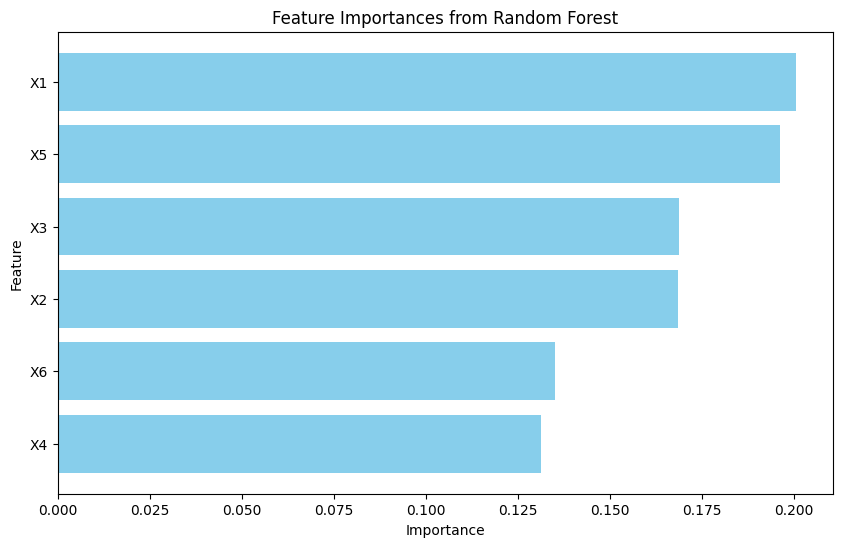

In [37]:
# Extract the RandomForestClassifier from the pipeline
rf_model = rf.named_steps["model"]

# Check if the model has feature_importances_ attribute
if hasattr(rf_model, "feature_importances_"):
    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for feature importance ranking
    feature_names = X_train.columns  # Replace with the actual feature names
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The model does not support feature importances.")


Negative Recall: 0.375
              precision    recall  f1-score   support

           0       0.75      0.38      0.50        16
           1       0.44      0.80      0.57        10

    accuracy                           0.54        26
   macro avg       0.60      0.59      0.54        26
weighted avg       0.63      0.54      0.53        26



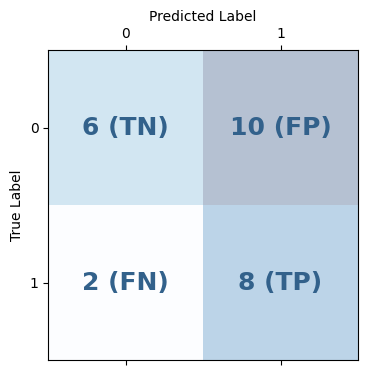

False Positive Rate (FPR): 0.625
Recall: 0.800
Negative Recall: 0.375
Precision: 0.444
F1 Score: 0.571


In [38]:
y_probs = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
Negative_Recall = (TN)/(TN+FP)
print('Negative Recall: '+'%.3f' % Negative_Recall)


# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Negative Recall: '+'%.3f' % Negative_Recall)

print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform

# Create Logistic Regression pipeline
log_pipe = Pipeline([
    ("model", LogisticRegression(random_state=42, max_iter=200))
])

# List of possible values for C using loguniform distribution
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr += 2

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Create a specificity scorer using make_scorer
specificity_scorer = make_scorer(specificity_score)


scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision",
    "specificity": specificity_scorer 
}

# Define parameter distribution for RandomizedSearchCV
log_param_dist = {
    'model__C': loguniform(C_list[0], C_list[-1]),  # Regularization strength
    'model__penalty': ['none', 'l1', 'l2'],  # No regularization, L1, and L2 regularization
    'model__class_weight': [None, "balanced"]  # Class weight options
}

# RandomizedSearchCV with multiple scoring metrics
os_log_rs = RandomizedSearchCV(log_pipe, param_distributions=log_param_dist, n_iter=60, 
                               scoring=scoring,
                               cv=StratifiedKFold(n_splits=5), refit="specificity", 
                               random_state=42, return_train_score=True)

# Fit the model
os_log_rs.fit(X_train, y_train)

# Print best parameters and results
print(f"Best parameters found: {os_log_rs.best_params_}")
print(f"Best score (specificity): {os_log_rs.best_score_}")


Best parameters found: {'model__C': np.float64(0.05967677008623393), 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Best score (specificity): 0.6142857142857142


In [71]:
os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_specificity", ascending=False)[
    ["param_model__C", "param_model__class_weight",
    "mean_test_accuracy", "mean_test_recall", "mean_test_f1", "mean_test_specificity"]].head()

,param_model__C,param_model__class_weight,mean_test_accuracy,mean_test_recall,mean_test_f1,mean_test_specificity
10,0.059677,balanced,0.624837,0.629091,0.658480,0.614286
17,0.121030,balanced,0.613725,0.629091,0.651111,0.589286
39,113.453378,balanced,0.568627,0.610909,0.619198,0.507143
32,1393.884577,balanced,0.568627,0.610909,0.619198,0.507143
4,129.993911,balanced,0.568627,0.610909,0.619198,0.507143


AUC value: 0.5402777777777777


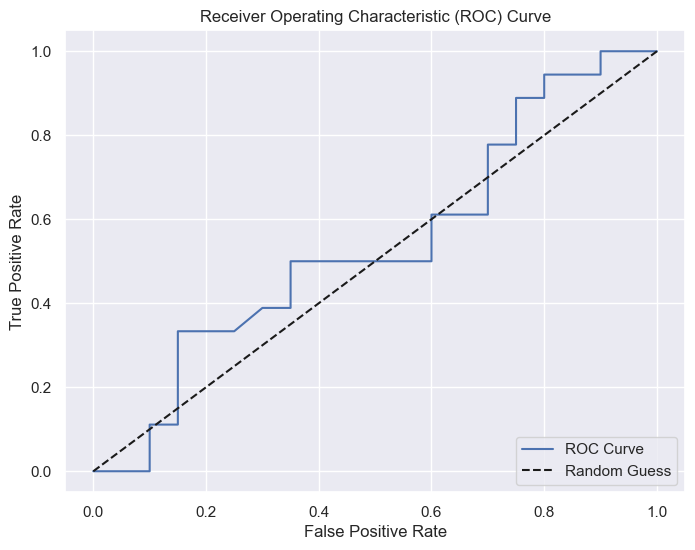

In [72]:
predictions_pa = os_log_rs.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

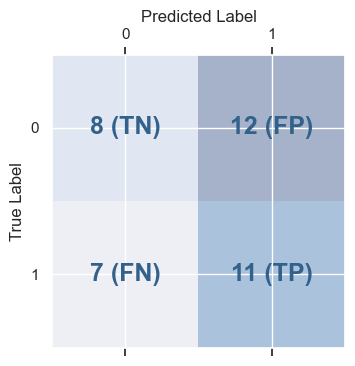

False Positive Rate (FPR): 0.600
Recall: 0.611
Precision: 0.478
F1 Score: 0.537


In [73]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = os_log_rs.predict(X_test))
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)


pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

In [74]:
best_model = os_log_rs.best_estimator_

# Accessing the coefficients of the logistic regression model
coefficients = best_model.named_steps['model'].coef_[0]

print("Coefficients of the best logistic regression model:")
print(coefficients)
print('Intercept of the best logistic regression model:')
print(coefficients[0])

Coefficients of the best logistic regression model:
[ 0.22881131 -0.00578532  0.20848359 -0.04577755  0.23181849  0.15422497]
Intercept of the best logistic regression model:
0.22881131301555052


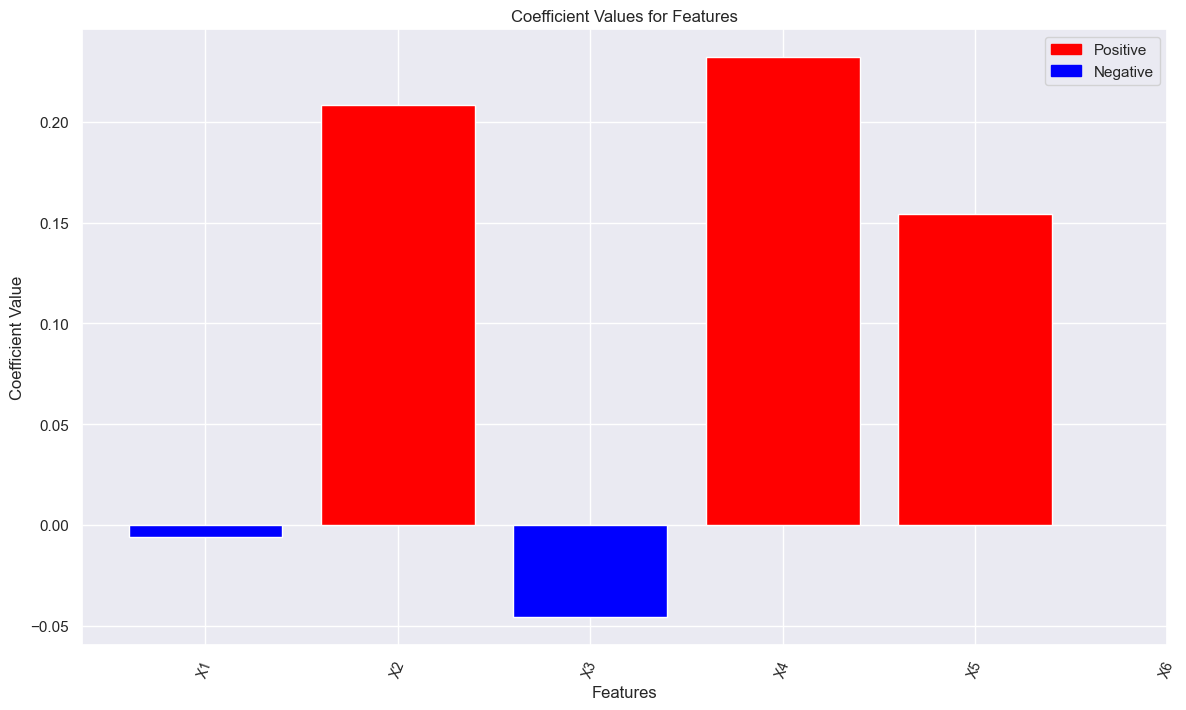

In [75]:
plot_coefs(coefficients[1:], feature_names, 'Coefficient Values for Features')
